# Задача 3

Из методов решения задач классификации есть линейные методы (e.g., логистическая регрессия), логические методы (e.g., решающие деревья), композиции алгоритмов (e.g., бустинг, решающие леса). В данной задаче я буду использовать gradient tree boosting. Мне кажется, некоторая информация в данных хорошо будет разбираться решающими деревьями. 

К примеру, вряд ли есть какая-то линейная зависимость между временем вылета и задержкой - однако задержки могут чаще происходить вечером или ночью - то есть логические условия по типу DepTime > t могут быть полезными. 
Похожая ситуация с Distance - мне кажется, возможная задержка скорее будет зависить от того, дальний это перелет или ближний, а не от конкретного расстояния.

Кроме этого градиентные бустинги - просто хороший метод классификации.

In [146]:
import numpy as np
import pandas
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [159]:
raw_data = pandas.read_csv('flight_delays_train.csv')

raw_data

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N


Теперь нужно обработать данные. Из столбцов с датами извлечем значения, убрав приставку "-c".
Время преобразуем в абсолютное в минутах, посчитав сумму (час * 60 + минуты). Целевую переменную преобразуем из Y-N в 1-0

In [169]:
def preprocess(df):
    new_df = df.copy()
    new_df[['Month', 'DayofMonth', 'DayOfWeek']] = new_df[['Month', 'DayofMonth', 'DayOfWeek']].apply(lambda c: list(map(lambda s: s[2:], c)))
    new_df['DepTime'] = new_df['DepTime'].map(lambda t: t//100 * 60 + t%100)
    new_df['dep_delayed_15min'] = new_df['dep_delayed_15min'].map(lambda x: 1 if x == 'Y' else (0 if x == 'N' else -1))
    return new_df

data = preprocess(raw_data)
data

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1174,AA,ATL,DFW,732,0
1,4,20,3,948,US,PIT,MCO,834,0
2,9,2,5,862,XE,RDU,CLE,416,0
3,11,25,6,615,OO,DEN,MEM,872,0
4,10,7,6,1108,WN,MDW,OMA,423,1
...,...,...,...,...,...,...,...,...,...
99995,5,4,3,978,OO,SFO,RDD,199,0
99996,1,18,3,484,CO,EWR,DAB,884,0
99997,1,24,2,1141,NW,DTW,IAH,1076,0
99998,4,27,4,915,MQ,DFW,GGG,140,0


array([[<AxesSubplot:title={'center':'DepTime'}>,
        <AxesSubplot:title={'center':'Distance'}>]], dtype=object)

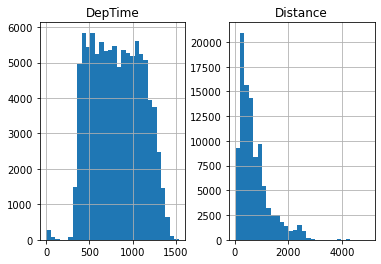

In [172]:
data.hist(column=['DepTime', 'Distance'], bins=30)

Категориальные признаки (дата, UniqueCarrier, Origin, Dest) закодируем OneHotEncoder'ом. 

In [174]:
def OneHotEncoder(df):
    unique_values = df.unique()
    code = {unique_values[i] : i for i in range(len(unique_values))}
    encoded = np.zeros((df.shape[0], df.nunique()))
    for i, val in enumerate(df):
        encoded[i, code[val]] = 1
    return encoded
    
month_onehot = OneHotEncoder(data['Month'])
dayOfWeek_onehot = OneHotEncoder(data['DayOfWeek'])
uniqueCarrier_onehot = OneHotEncoder(data['UniqueCarrier'])
origin_onehot = OneHotEncoder(data['Origin'])
dest_onehot = OneHotEncoder(data['Dest'])
depTime_scaled = (data['DepTime'] - np.mean(data['DepTime'])) / np.std(data['DepTime'])
distance_scaled = (data['Distance'] - np.mean(data['Distance'])) / np.std(data['Distance'])


X = np.hstack((month_onehot, dayOfWeek_onehot))
X = np.hstack((X, uniqueCarrier_onehot))
X = np.hstack((X, origin_onehot))
X = np.hstack((X, dest_onehot))
X = np.hstack((X, depTime_scaled[:, None]))
X = np.hstack((X, distance_scaled[:, None]))
y = data['dep_delayed_15min']

X.shape

(100000, 621)

Получилась таблица размера (100000, 621). Попробуем уменьшить размерность с помощью truncatedSVD. Я выбрал количество компонент такое, чтобы новая матрица объясняла 90% дисперсии.

In [176]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=random_state)
svd.fit(X)
reduced_X = svd.transform(X)
svd.explained_variance_ratio_.sum()

0.9013907417351718

На кросс-валидации по пяти блокам проверим значение roc-auc score.

In [179]:
random_state = 42

clf = GradientBoostingClassifier(n_estimators=100, random_state=random_state)
print(cross_val_score(clf, reduced_X, y, cv=5, scoring='roc_auc'))

[0.7255139  0.71891583 0.72559357 0.71374691 0.72641091]


Значения стабильно выше 0.7 - классификатор хороший. Но cross_val_score делает копию классификатора, поэтому fit там не делается. Поделим нашу выборку в соотношении 80/20, сделаем fit.

In [180]:
X_train, X_test, y_train, y_test = train_test_split(reduced_X, y, test_size=0.2, random_state=random_state)
clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

Заодно еще раз проверим качество оценки на X_test

In [181]:
y_pred = clf.predict_proba(X_test)[:,1]
#y_pred
roc_auc_score(y_test, y_pred)

0.7254197549106727

Оценка опять значительно выше 0.7 - классифиактор справляется с задачей. Теперь построим прогноз по тестовым данным.

In [184]:
raw_data_test = pandas.read_csv('flight_delays_test.csv')
data_test = raw_data_test.copy()

data_test[['Month', 'DayofMonth', 'DayOfWeek']] = data_test[['Month', 'DayofMonth', 'DayOfWeek']].apply(lambda c: list(map(lambda s: s[2:], c)))
data_test['DepTime'] = data_test['DepTime'].map(lambda t: t//100 * 60 + t%100)

data_test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,7,25,3,375,YV,MRY,PHX,598
1,4,17,2,459,WN,LAS,HOU,1235
2,12,2,7,411,MQ,GSP,ORD,577
3,3,25,7,974,WN,BWI,MHT,377
4,6,6,3,905,UA,ORD,STL,258
...,...,...,...,...,...,...,...,...
99995,6,5,2,532,WN,CRP,HOU,187
99996,11,24,6,886,UA,ORD,LAS,1515
99997,1,30,2,909,OO,ORD,SGF,438
99998,1,5,5,484,DL,LGA,ATL,761


In [187]:
month_onehot_test = OneHotEncoder(data_test['Month'])
dayOfWeek_onehot_test = OneHotEncoder(data_test['DayOfWeek'])
uniqueCarrier_onehot_test = OneHotEncoder(data_test['UniqueCarrier'])
origin_onehot_test = OneHotEncoder(data_test['Origin'])
dest_onehot_test = OneHotEncoder(data_test['Dest'])
depTime_scaled_test = (data_test['DepTime'] - np.mean(data_test['DepTime'])) / np.std(data_test['DepTime'])
distance_scaled_test = (data_test['Distance'] - np.mean(data_test['Distance'])) / np.std(data_test['Distance'])


X_test = np.hstack((month_onehot_test, dayOfWeek_onehot_test))
X_test = np.hstack((X_test, uniqueCarrier_onehot_test))
X_test = np.hstack((X_test, origin_onehot_test))
X_test = np.hstack((X_test, dest_onehot_test))
X_test = np.hstack((X_test, depTime_scaled_test[:, None]))
X_test = np.hstack((X_test, distance_scaled_test[:, None]))

svd.fit(X_test)
reduced_X_test = svd.transform(X_test)
svd.explained_variance_ratio_.sum()

0.8983122099687886

In [214]:
y_pred = clf.predict_proba(reduced_X_test)[:,1]
y_pred

array([0.06552951, 0.09879599, 0.09045105, ..., 0.21076451, 0.15340155,
       0.09173449])